In [35]:
import sys, os, glob, warnings, logging
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest
from sw_qPCR import *

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [36]:
# Read in data from different plates and combine them
plate_ids = ['220525-plate3', '220525-plate4', '220525-plate5',
             '220613-plate1', '220613-plate2', '220613-plate5']
dfs = []
for plate_id in plate_ids:
    dfs.append(get_plate_data(plate_id))

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)

# Add a few helpful columns
df['group'] = [df.Sample[i] + '___' + df.Primer[i] for i in range(len(df))]
df['well_id'] = [df.plate_id[i] + '-' + df.Well[i] for i in range(len(df))]
df['relExp_25'] = [2**(25-df.Cq[i]) for i in range(len(df))]

df.head()

,Well,Sample,Primer,Cq,plate_id,sgRNA_id,group,well_id,relExp_25
0,A01,1-188-1,Rps29 v1,19.870996,220525-plate3,188,1-188-1___Rps29 v1,220525-plate3-A01,34.993241
1,A02,1-188-1,Rps29 v1,19.804993,220525-plate3,188,1-188-1___Rps29 v1,220525-plate3-A02,36.631362
2,A03,1-188-1,Rps29 v1,19.605794,220525-plate3,188,1-188-1___Rps29 v1,220525-plate3-A03,42.055027
3,A04,1-188-1,Itgb1 sg1 v1,23.618603,220525-plate3,188,1-188-1___Itgb1 sg1 v1,220525-plate3-A04,2.605206
4,A05,1-188-1,Itgb1 sg1 v1,23.529432,220525-plate3,188,1-188-1___Itgb1 sg1 v1,220525-plate3-A05,2.771309


In [37]:
# # Insepct the amplification and melting curves of each plate to check
# # if there are problematic data that should be excluded
# plate_ids = ['220525-plate3', '220525-plate4', '220525-plate5',
#              '220613-plate1', '220613-plate2', '220613-plate5']
# for plate_id in plate_ids:
#     plot_amplification_curves(plate_id)
#     plot_melting_curves(plate_id)

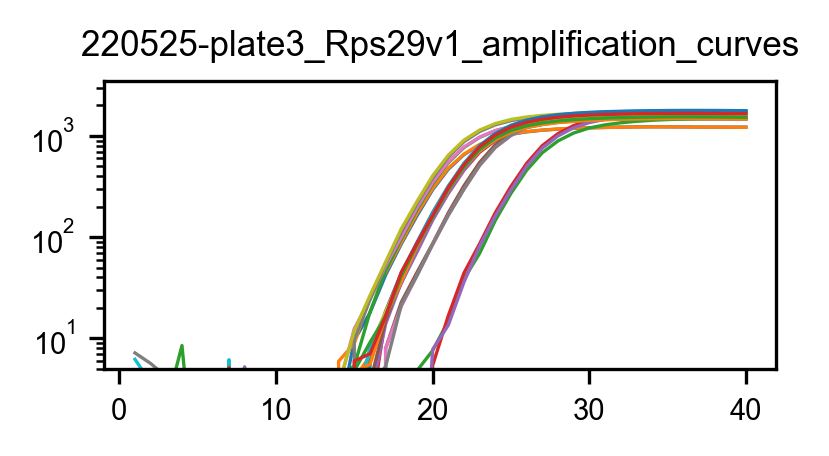

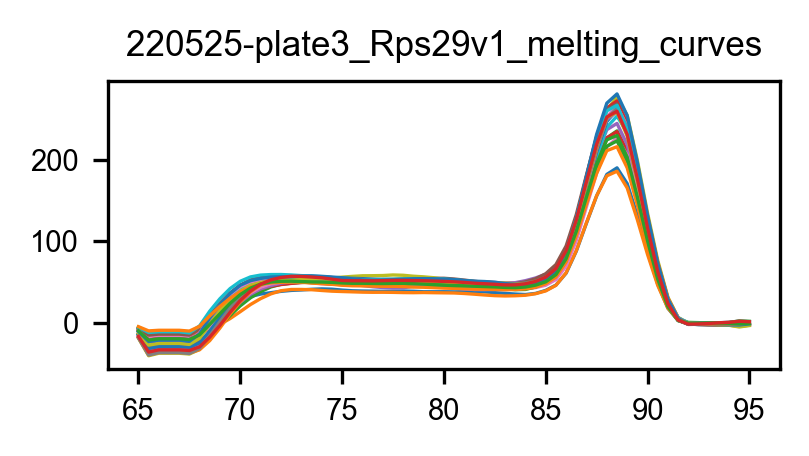

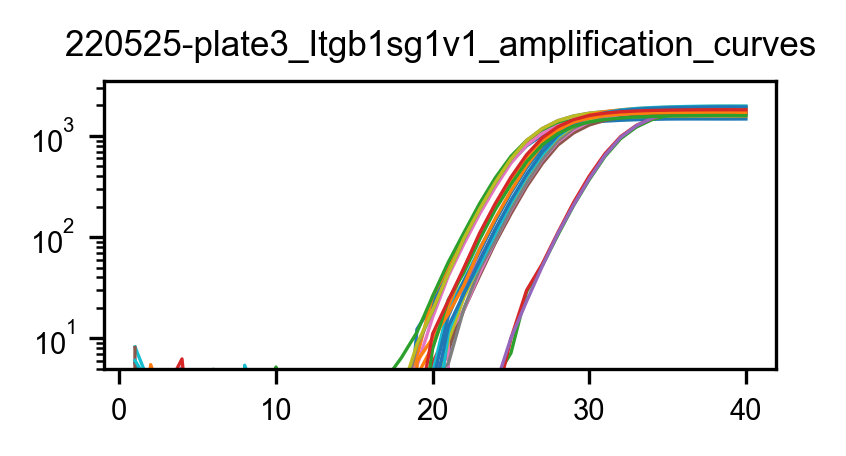

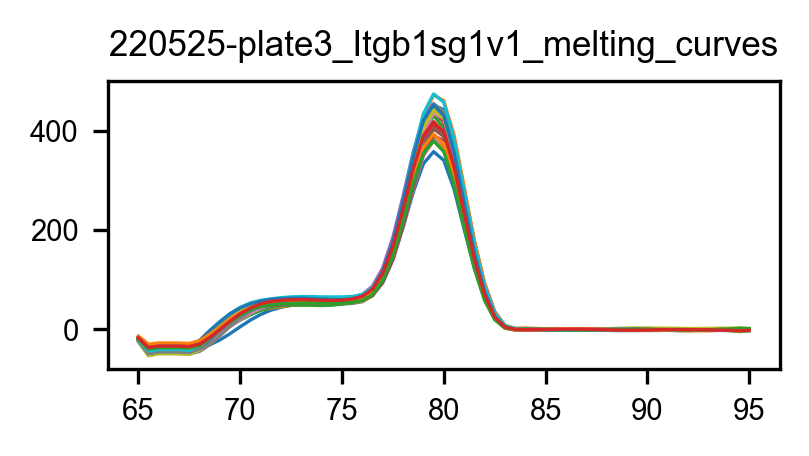

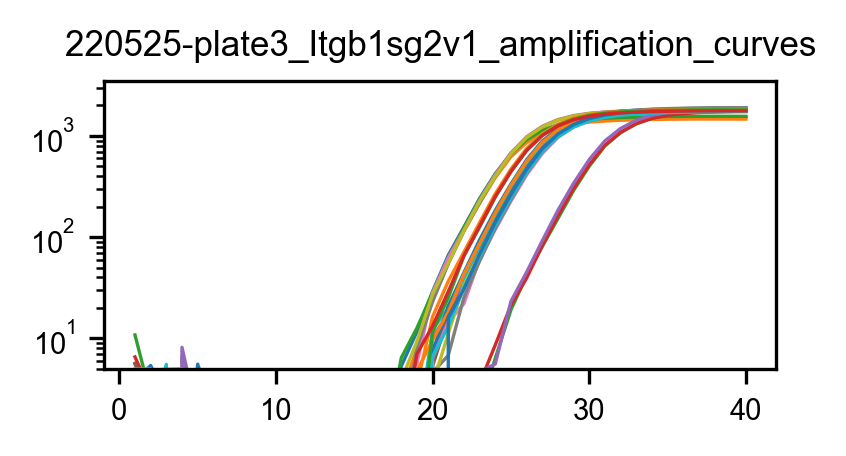

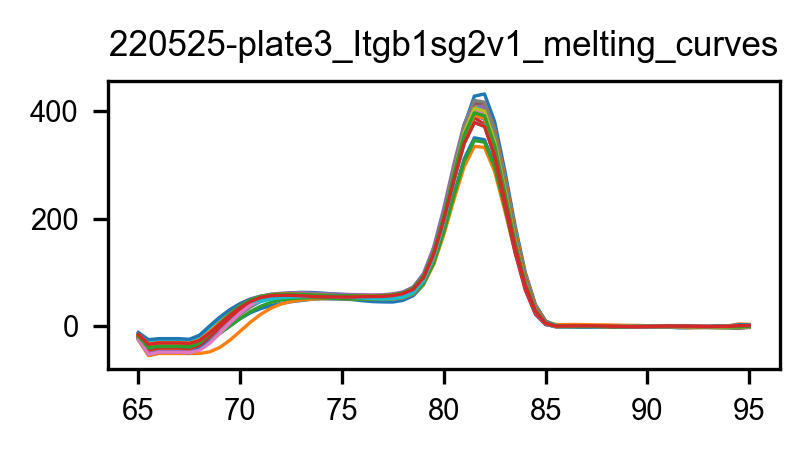

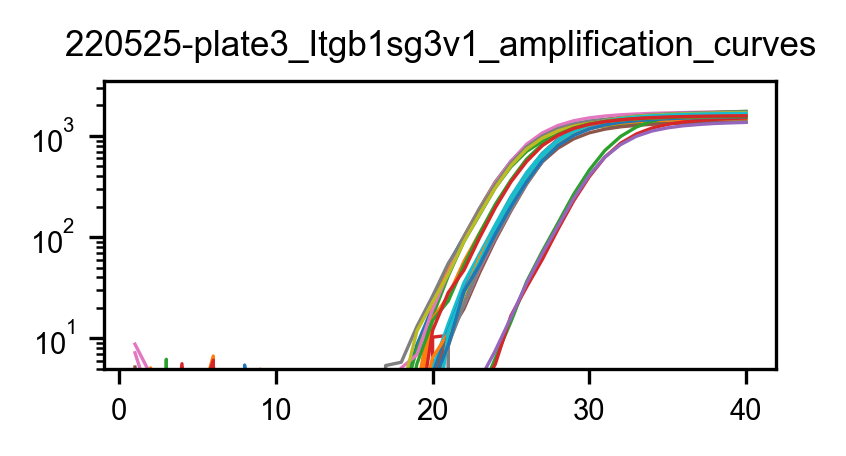

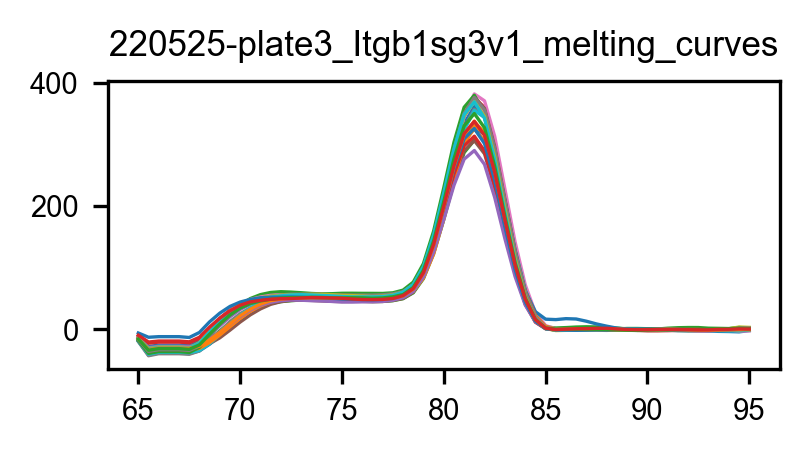

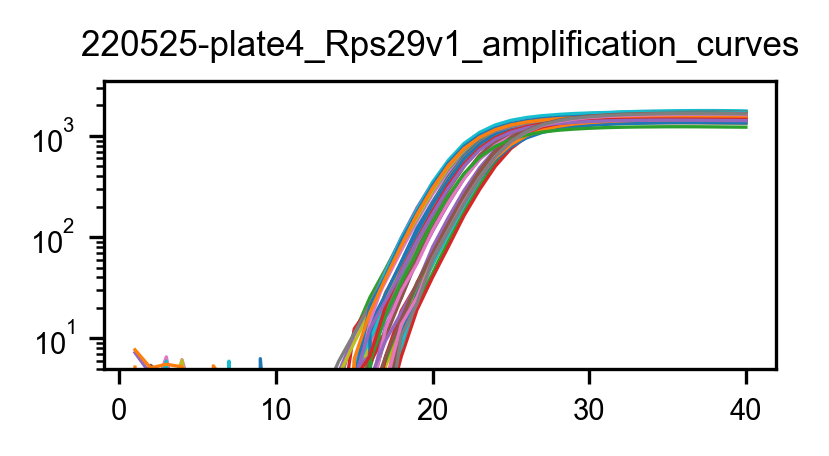

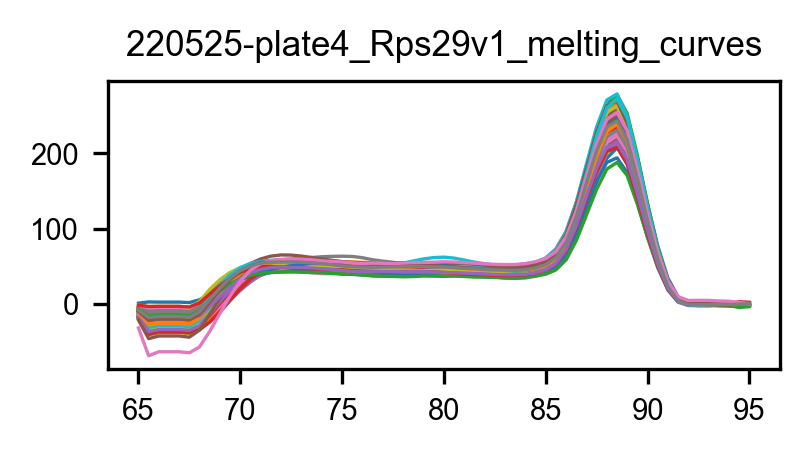

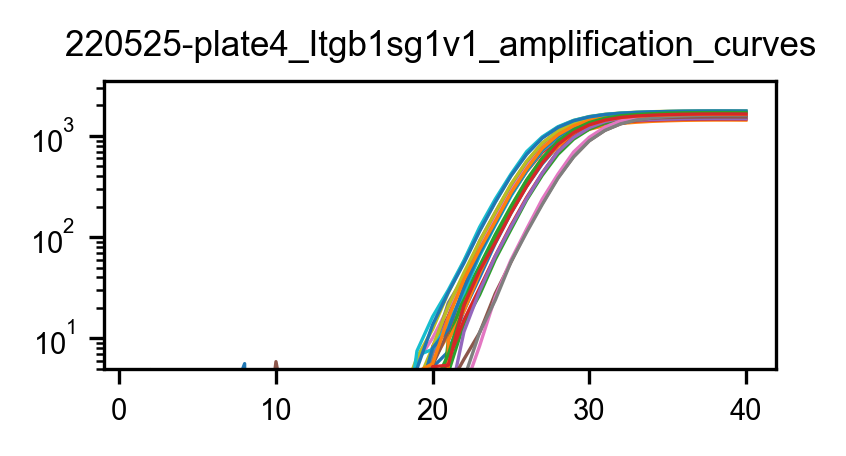

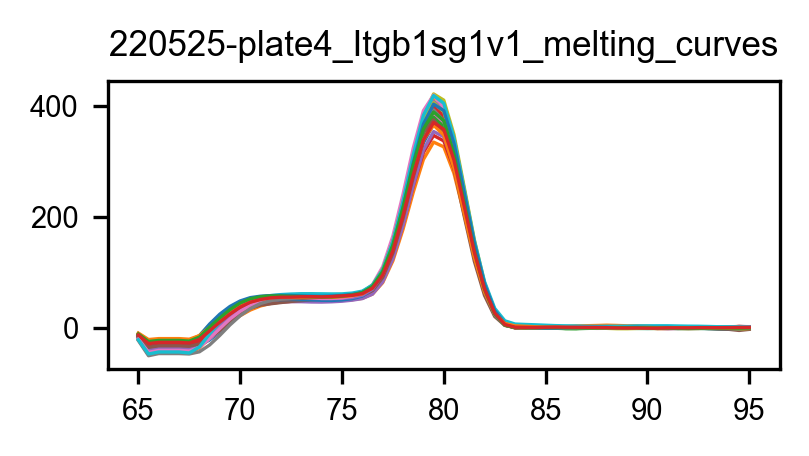

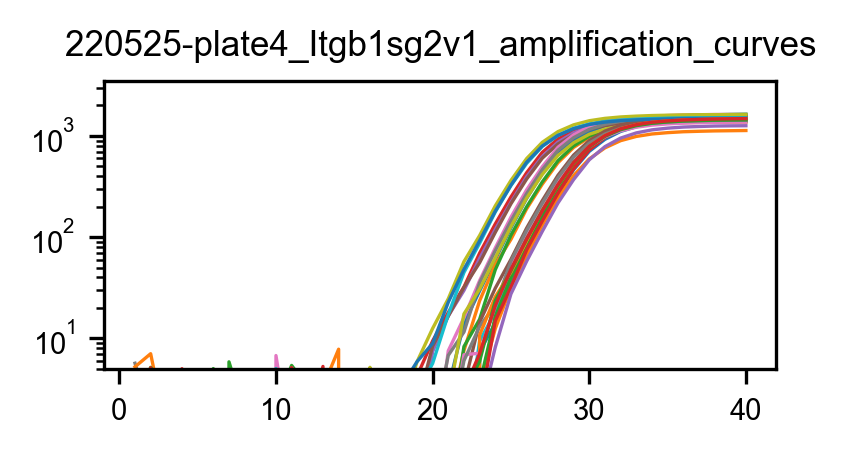

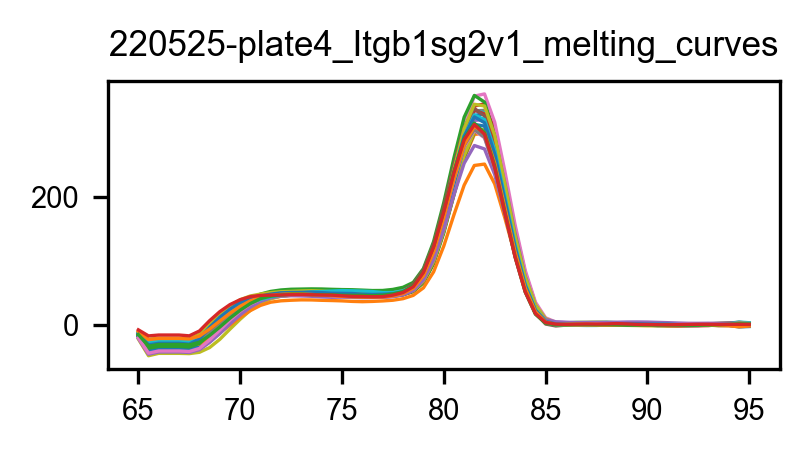

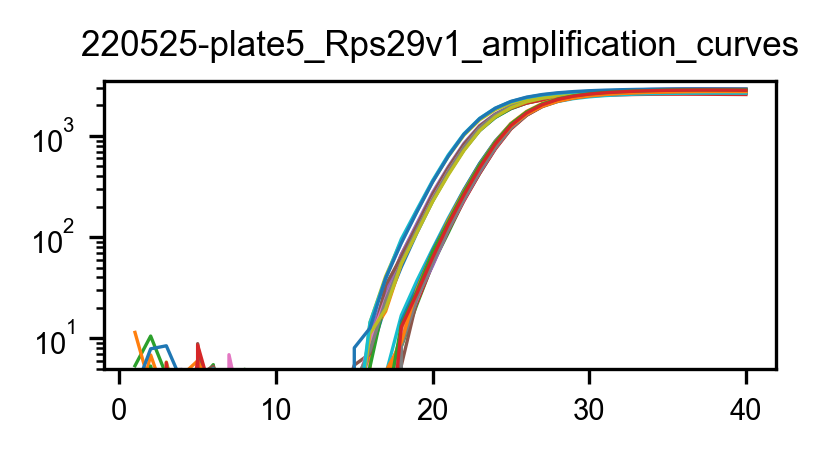

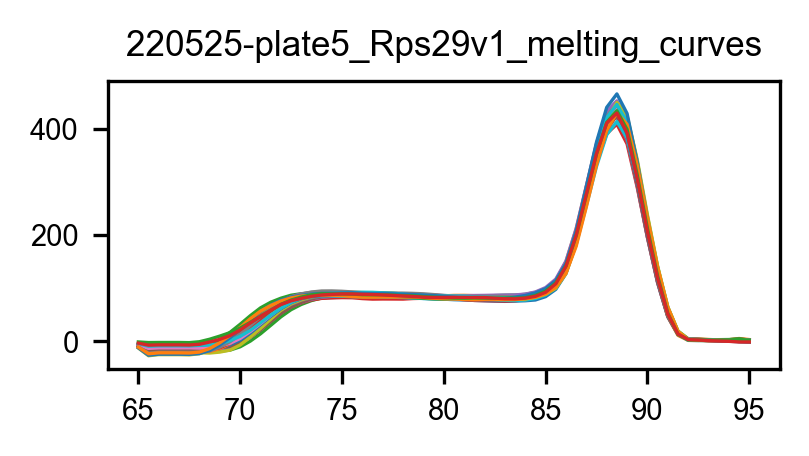

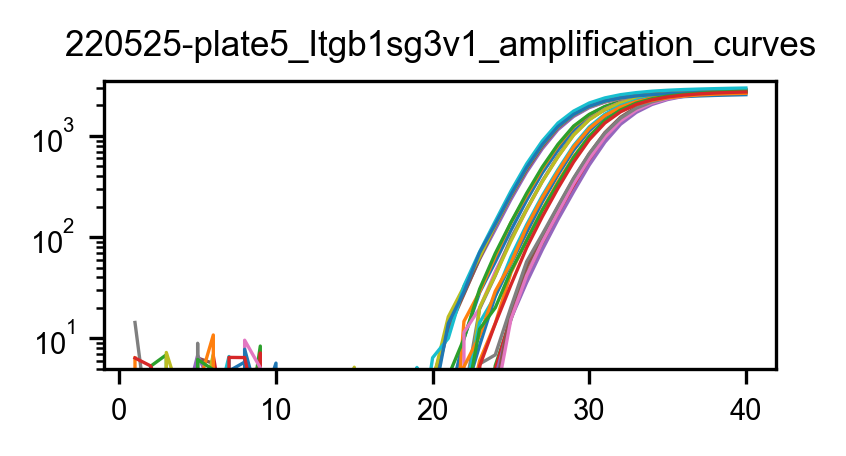

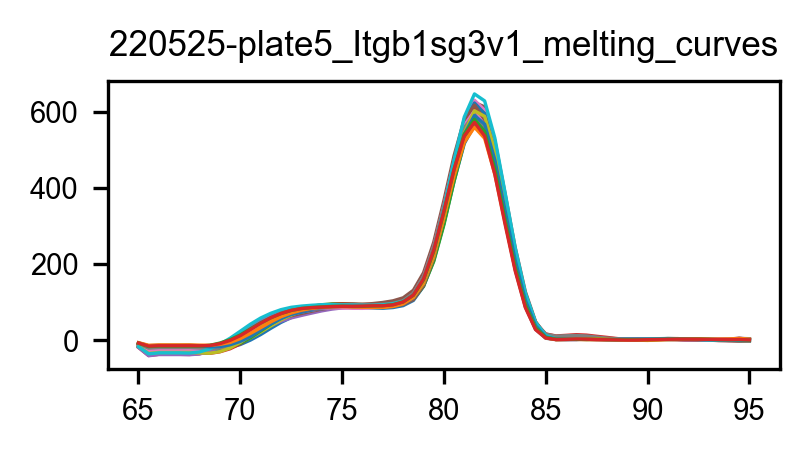

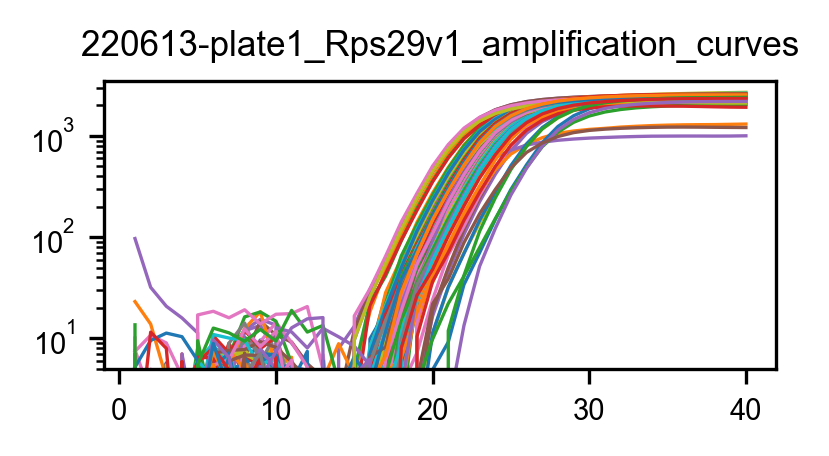

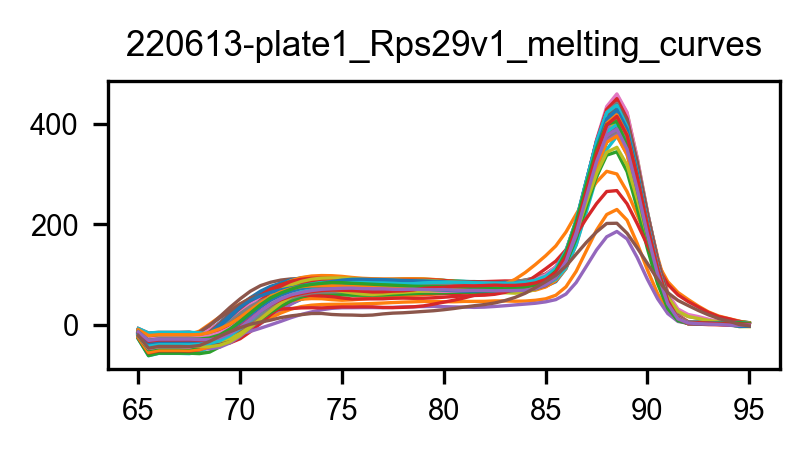

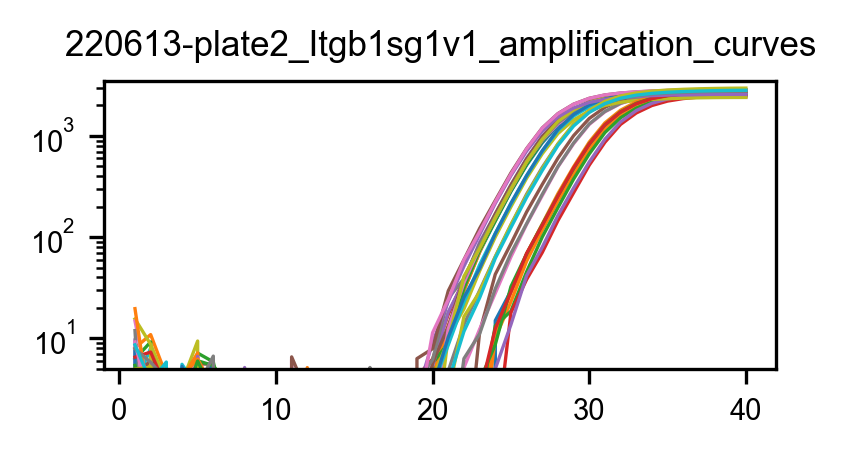

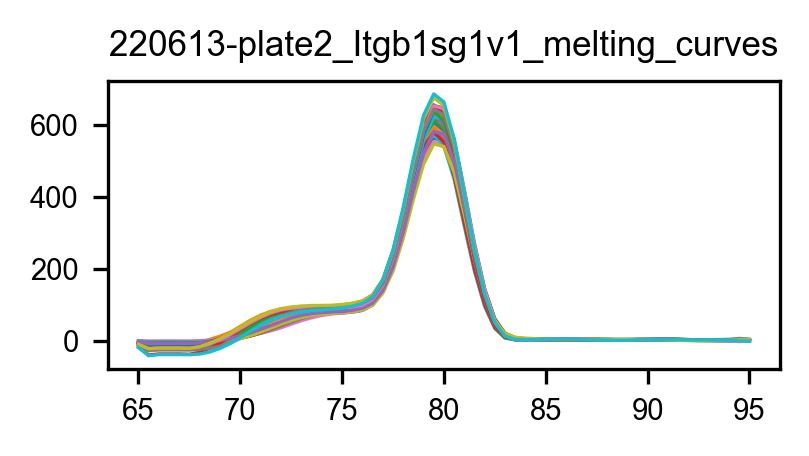

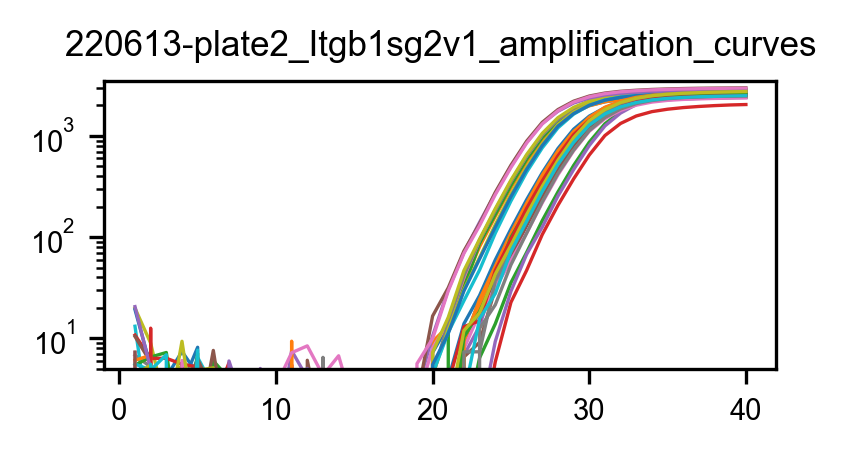

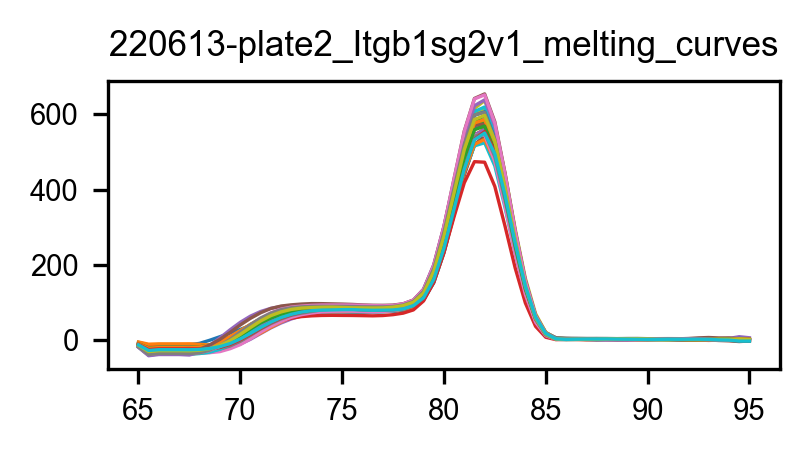

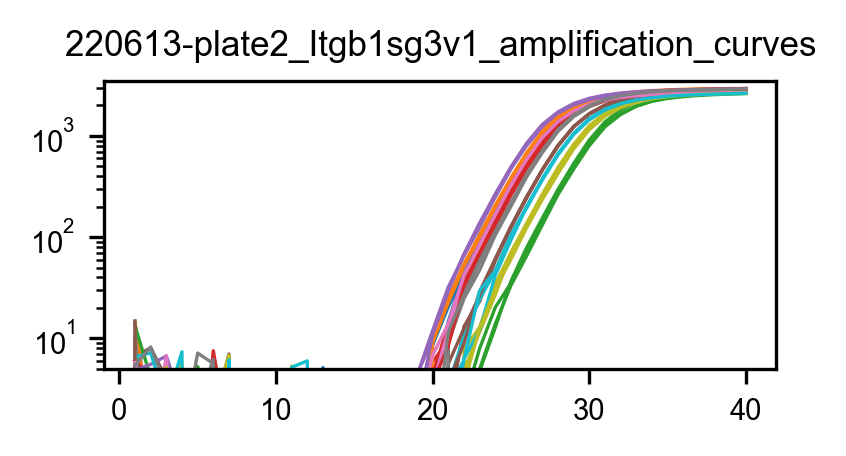

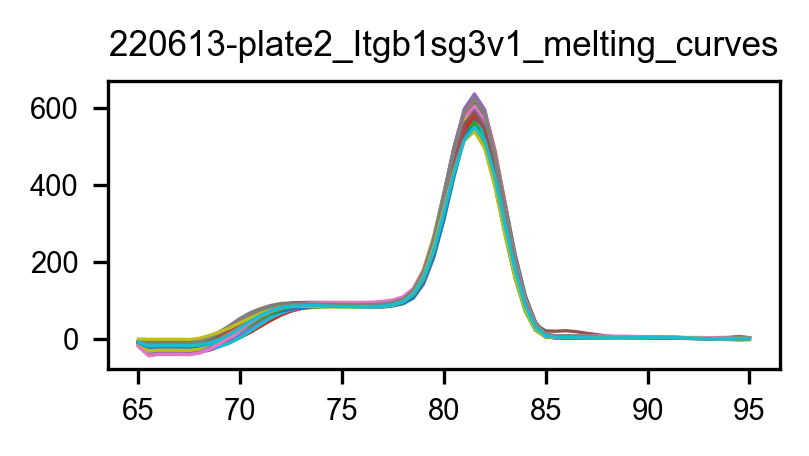

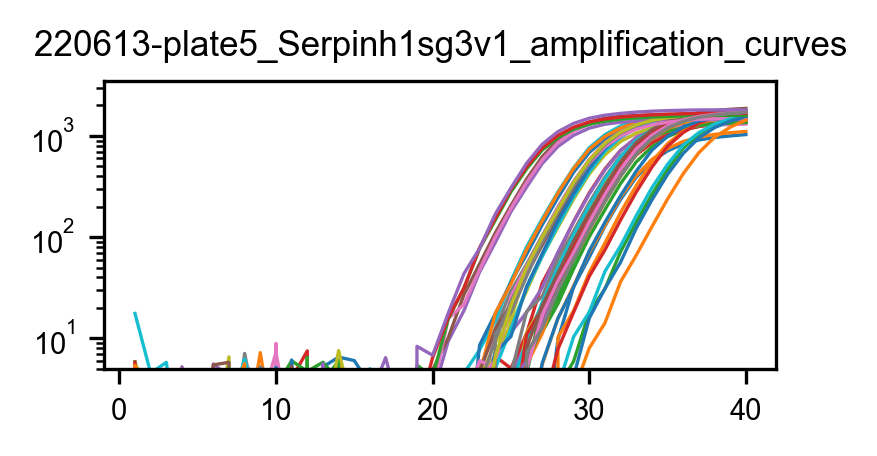

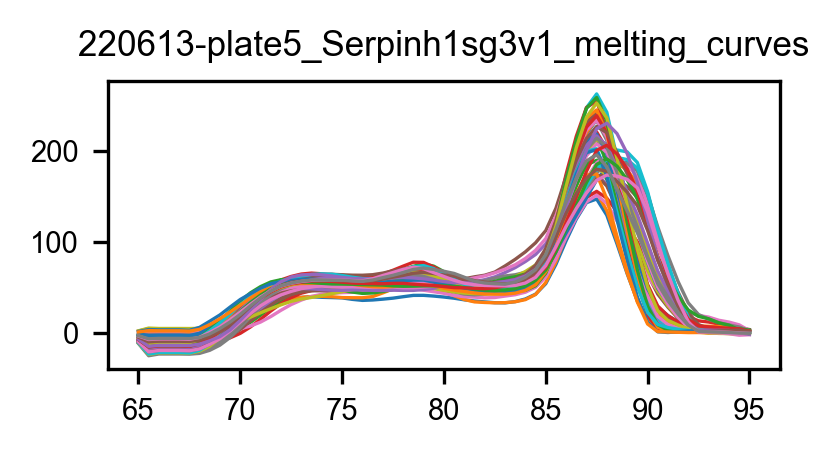

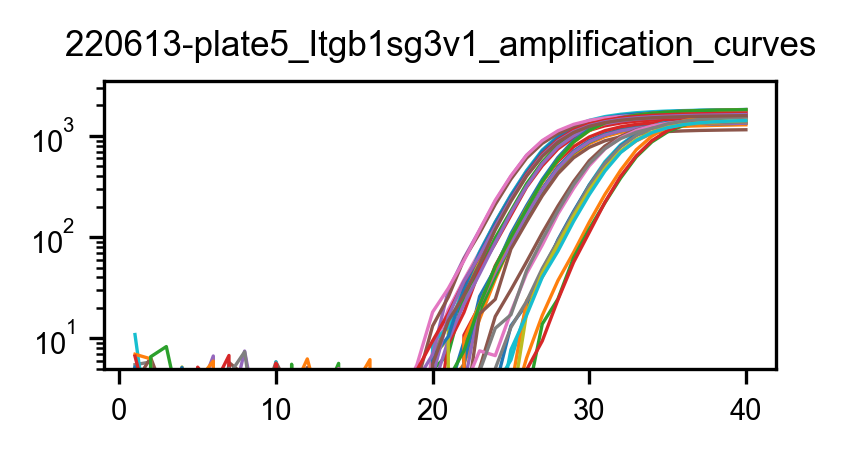

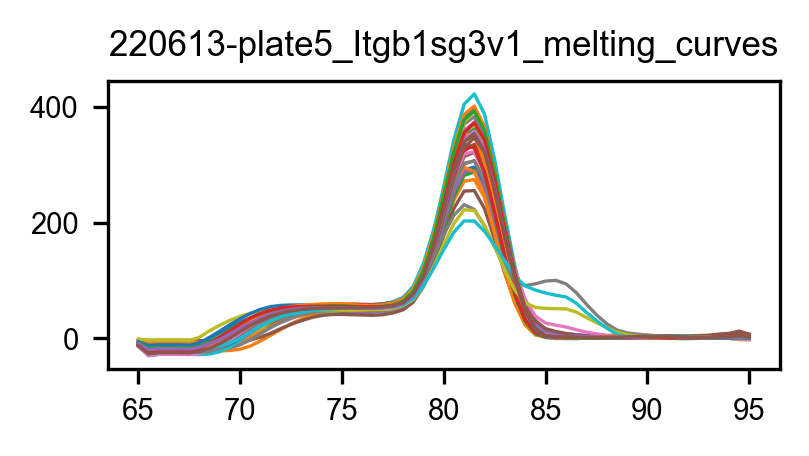

In [4]:
# Insepct the amplification and melting curves of each plate per primer to check
# if there are problematic data that should be excluded
plate_ids = ['220525-plate3', '220525-plate4', '220525-plate5',
             '220613-plate1', '220613-plate2', '220613-plate5']
for plate_id in plate_ids:
    df_annotation = get_annotation_data(plate_id)
    for primer in df_annotation.Primer.unique():
        plot_amplification_curves(plate_id, primer)
        plot_melting_curves(plate_id, primer)

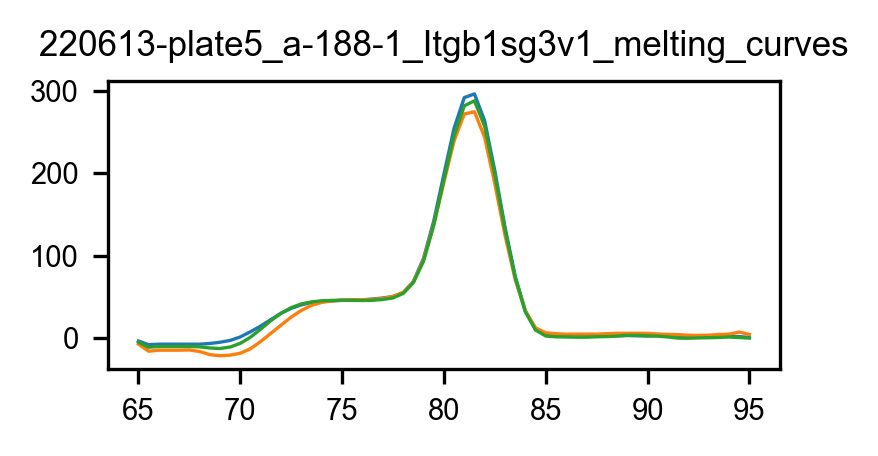

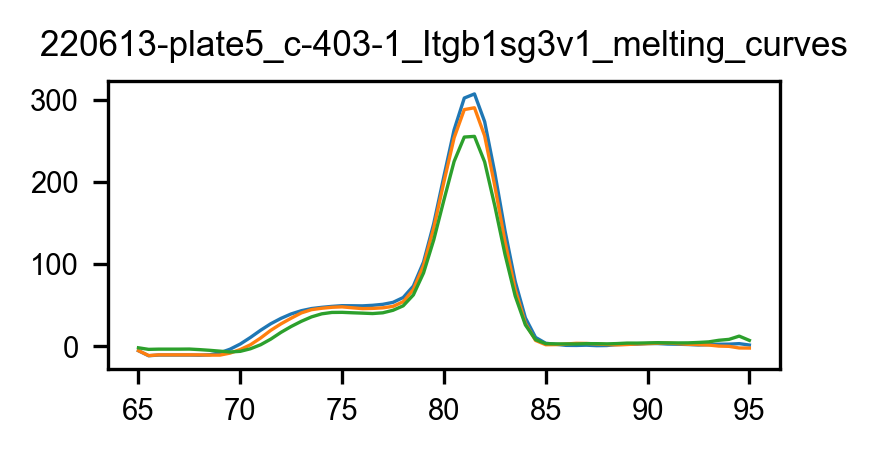

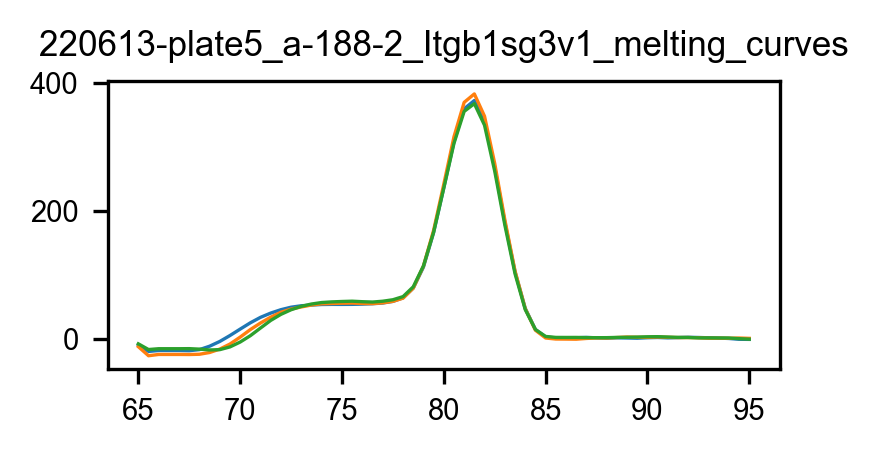

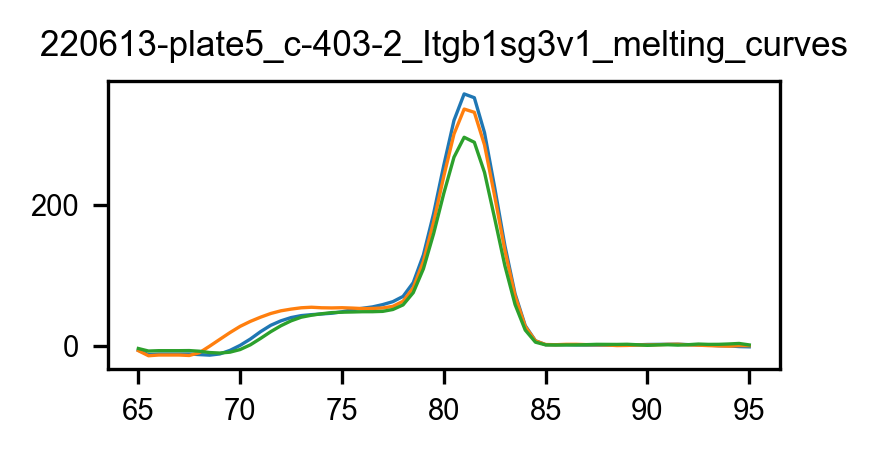

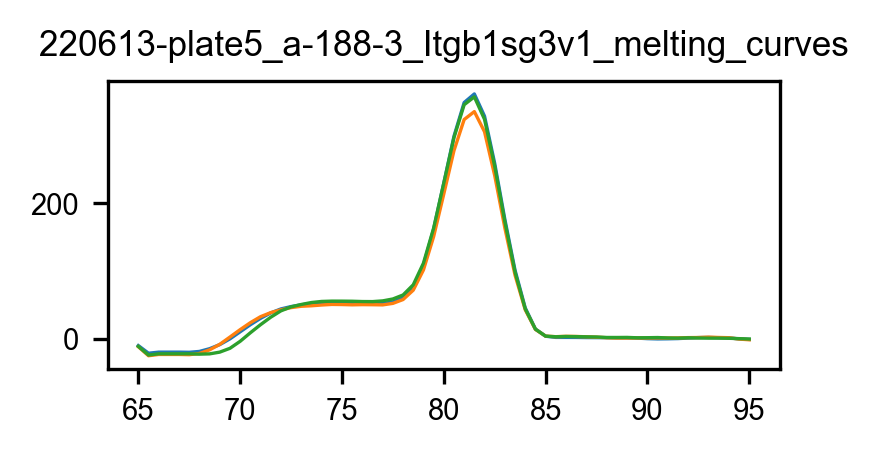

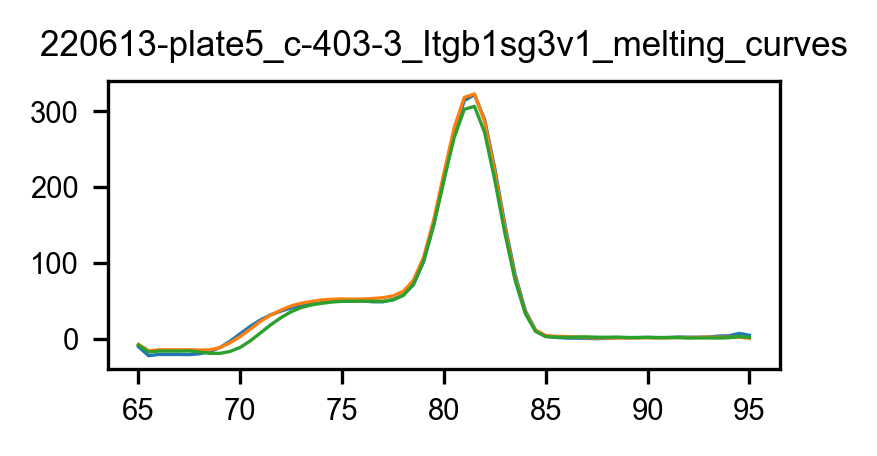

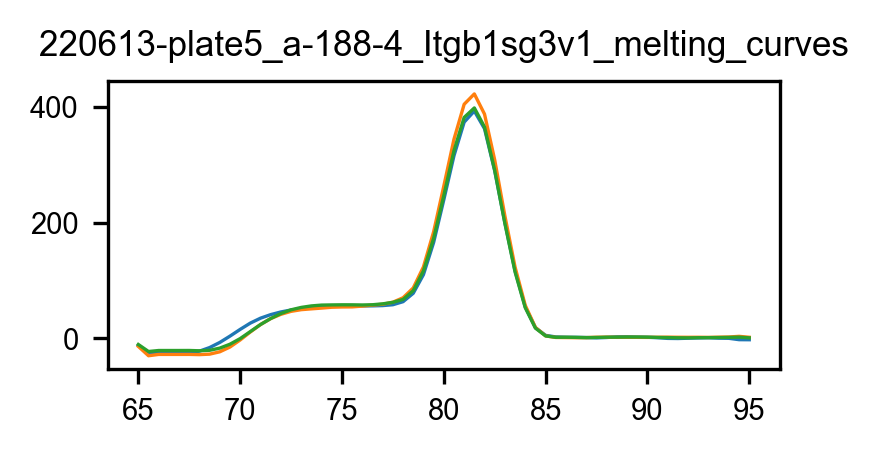

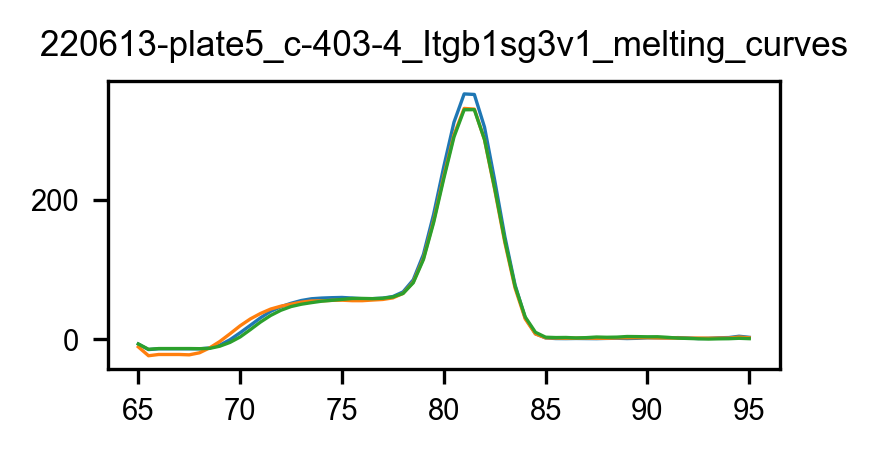

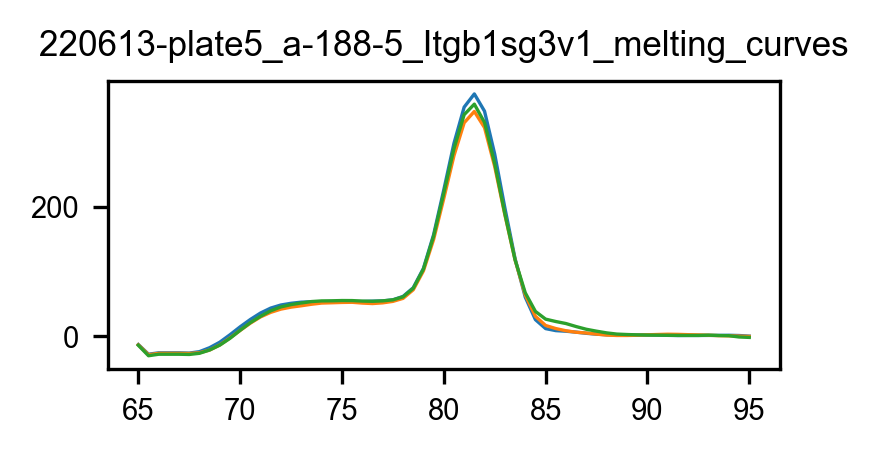

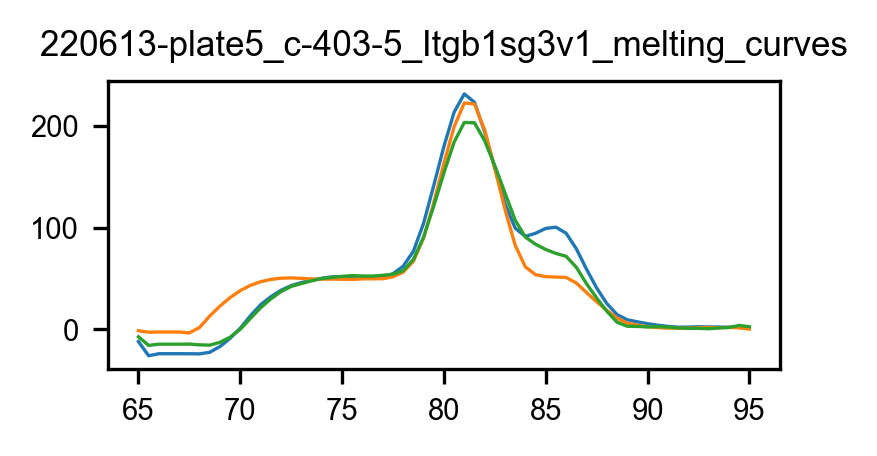

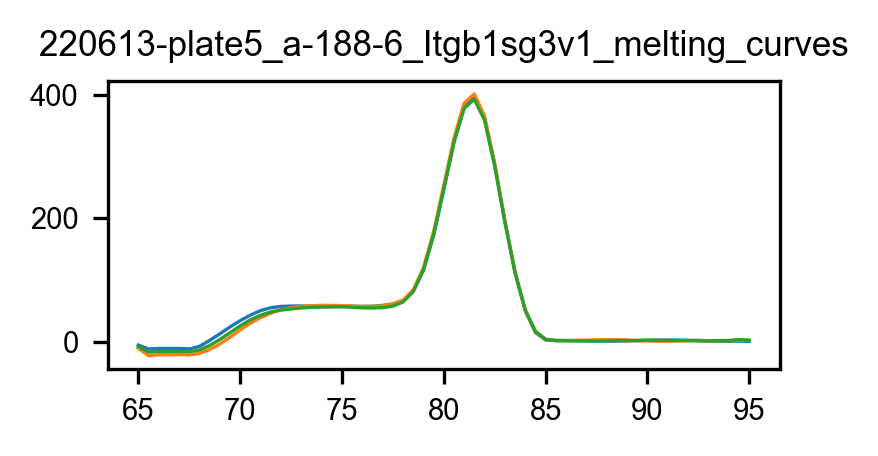

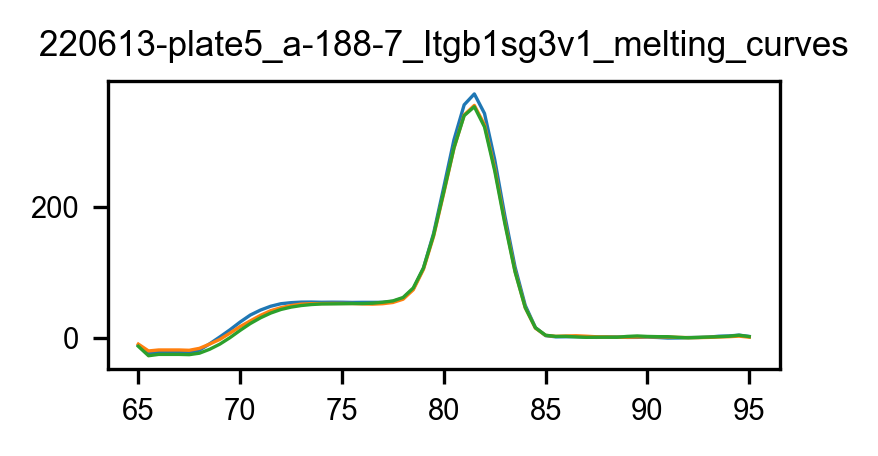

In [5]:
# One set above has some problematic melting curves
# Split by samples to narrow down which ones they belong to

plate_id = '220613-plate5'
primer = 'Itgb1 sg3 v1'
df_annotation = get_annotation_data(plate_id)
for sample in df_annotation.Sample.unique():
    plot_melting_curves(plate_id, primer, sample=sample, save_fig=False)

In [38]:
df.shape

(510, 9)

In [39]:
# By inspecting the curves above, curate a list of samples to exclude
samples_to_exclude = ['c-403-5']

df = df[~df.Sample.isin(samples_to_exclude)]
df.reset_index(drop=True, inplace=True)

In [40]:
df = remove_outliers(df)

In [41]:
df.shape

(498, 9)

In [42]:
df.head()

,Well,Sample,Primer,Cq,plate_id,sgRNA_id,group,well_id,relExp_25
0,A01,1-188-1,Rps29 v1,19.870996,220525-plate3,188,1-188-1___Rps29 v1,220525-plate3-A01,34.993241
1,A02,1-188-1,Rps29 v1,19.804993,220525-plate3,188,1-188-1___Rps29 v1,220525-plate3-A02,36.631362
2,A03,1-188-1,Rps29 v1,19.605794,220525-plate3,188,1-188-1___Rps29 v1,220525-plate3-A03,42.055027
3,A04,1-188-1,Itgb1 sg1 v1,23.618603,220525-plate3,188,1-188-1___Itgb1 sg1 v1,220525-plate3-A04,2.605206
4,A05,1-188-1,Itgb1 sg1 v1,23.529432,220525-plate3,188,1-188-1___Itgb1 sg1 v1,220525-plate3-A05,2.771309


In [43]:
df1 = get_expression_data(df, 'Itgb1 sg1 v1')

# Normalize expression level to the control group (make it 1)
control_relExp = df1[df1.sgRNA_id=='188'].relExp.mean()
df1['normed_relExp'] = df1.relExp / control_relExp

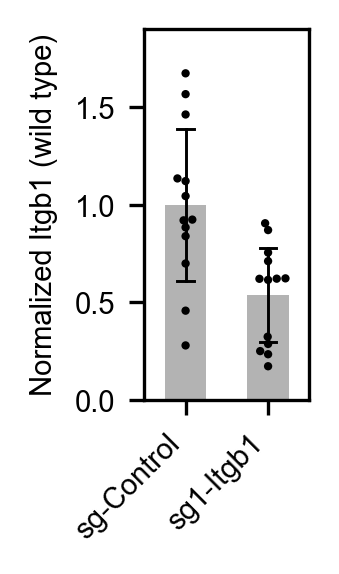

In [45]:
# Make plot for figure

fig_width, fig_height = 1.1, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Itgb1-sg1-combined'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.45, 0.3, 0.5, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df1,
              x = 'sgRNA_id', y = 'normed_relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df1,
            x = 'sgRNA_id', y = 'normed_relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 1.9])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg1-Itgb1']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel('Normalized Itgb1 (wild type)')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [46]:
df2 = get_expression_data(df, 'Itgb1 sg2 v1')

# Normalize expression level to the control group (make it 1)
control_relExp = df2[df2.sgRNA_id=='188'].relExp.mean()
df2['normed_relExp'] = df2.relExp / control_relExp

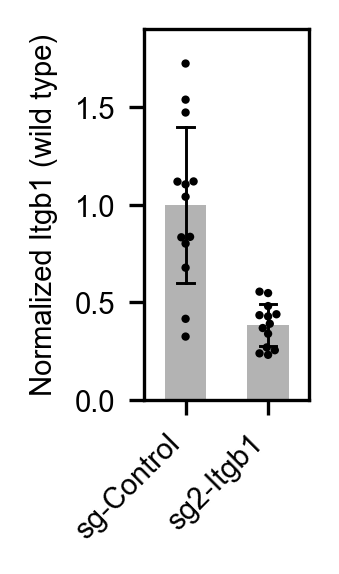

In [48]:
# Make plot for figure

fig_width, fig_height = 1.1, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Itgb1-sg2-combined'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.45, 0.3, 0.5, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df2,
              x = 'sgRNA_id', y = 'normed_relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df2,
            x = 'sgRNA_id', y = 'normed_relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 1.9])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg2-Itgb1']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel('Normalized Itgb1 (wild type)')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [49]:
df3 = get_expression_data(df, 'Itgb1 sg3 v1')

# Normalize expression level to the control group (make it 1)
control_relExp = df3[df3.sgRNA_id=='188'].relExp.mean()
df3['normed_relExp'] = df3.relExp / control_relExp

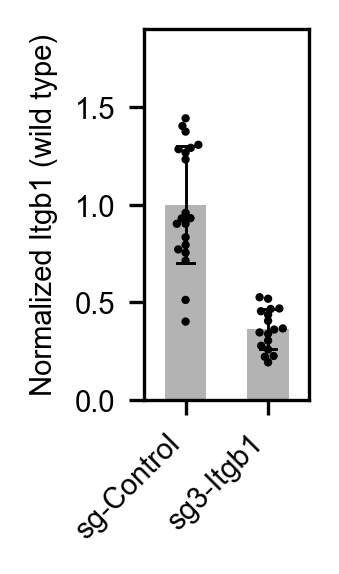

In [50]:
# Make plot for figure

fig_width, fig_height = 1.1, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Itgb1-sg3-combined'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.45, 0.3, 0.5, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df3,
              x = 'sgRNA_id', y = 'normed_relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df3,
            x = 'sgRNA_id', y = 'normed_relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 1.9])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg3-Itgb1']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel('Normalized Itgb1 (wild type)')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [51]:
df1.head()

,Sample,Cq_ref,relExp_25_x,Cq_test,relExp_25_y,deltaCq,relExp,Group,sgRNA_id,normed_relExp
0,1-188-1,19.760594,37.893210,23.503611,2.829045,3.743017,0.074686,1-188,188,1.566759
1,1-188-2,20.973606,16.315480,25.302116,0.811064,4.328509,0.049772,1-188,188,1.044122
2,1-188-3,19.399780,48.628622,23.625935,2.597428,4.226155,0.053432,1-188,188,1.120890
3,1-188-4,20.766016,18.824838,24.974736,1.018016,4.208720,0.054082,1-188,188,1.134518
4,1-188-5,24.878703,1.091954,29.384501,0.047909,4.505798,0.044017,1-188,188,0.923383


In [52]:
tukeyTest(df1.normed_relExp, df1.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   188    401  -0.4633 0.0019 -0.7374 -0.1892   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.00189628]


In [53]:
tukeyTest(df2.normed_relExp, df2.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   188    402  -0.6183 0.001 -0.8649 -0.3717   True
---------------------------------------------------
p values of all pair-wise tests:
 0.001


In [54]:
tukeyTest(df3.normed_relExp, df3.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   188    403  -0.6384 0.001 -0.7968 -0.4799   True
---------------------------------------------------
p values of all pair-wise tests:
 0.001


In [55]:
for i in df1.sgRNA_id.unique():
    print(i, 'n =', len(df1[df1.sgRNA_id==i]))

188 n = 13
401 n = 13


In [56]:
for i in df2.sgRNA_id.unique():
    print(i, 'n =', len(df2[df2.sgRNA_id==i]))

188 n = 13
402 n = 13


In [57]:
for i in df3.sgRNA_id.unique():
    print(i, 'n =', len(df3[df3.sgRNA_id==i]))

188 n = 20
403 n = 17
